## iZettle Data Science Assignment - CPV ##

Thanks for taking time to complete the iZettle data science assignment.
<br>
This is to give you an idea about the challenges that we may face at iZettle. Also, it will help us understand how you would tackle them.
<br>
Feel free to scope the assignment as appropriate. Make sure to motivate what you did and why.

The goal is to estimate the Card Payment Volume (CPV) of each organization
during their first, second and third month after creation (i.e. the sum of the
amount of every transaction in each month). The prediction should be based
on the first 14 days of data after the organization was created.

You’ll find two CSV files attached with the following data:

data/organization_ids.csv:
- organization_id Unique identifier for each organization
- organization_created Date on which organization was onboarded

data/payment_ids.csv:
- organization_id Unique identifier for each organization
- card_payment_id Unique identifier for a payment that was completed
- timestamp Time of event
- currency_id Currency
- amount Amount of the transaction
- device_type The device connected to the card reader
- card_payment_entry_mode Payment technology
- payment_type Valid payment or invalid

### Imports ###

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data Loading and Preparation ###

We'll load the 2 csv's, and merge them on the organization id.

In [2]:
payment_df = pd.read_csv('payment_ids.csv')

In [3]:
organization_df = pd.read_csv('organization_ids.csv')

In [4]:
master_df = pd.merge(payment_df, organization_df, on='organization_id')

<br>
<br>
Let's take a quick look at the categorical columns, and see how they're distributed.

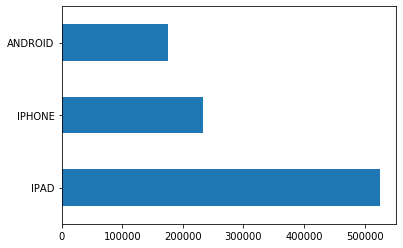

In [5]:
master_df['device_type'].value_counts().plot(kind='barh')

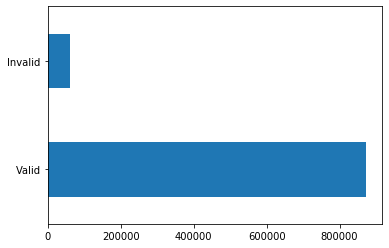

In [6]:
master_df['payment_type'].value_counts().plot(kind='barh')

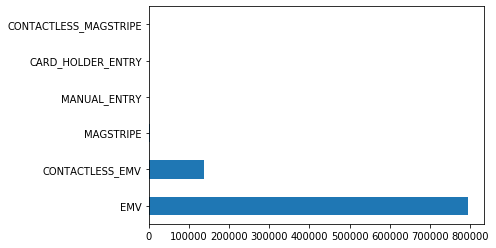

In [7]:
master_df['card_payment_entry_mode'].value_counts().plot(kind='barh')

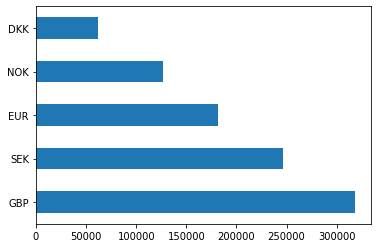

In [8]:
master_df['currency_id'].value_counts().plot(kind='barh')

<br>
<br>
Now we need to convert the time columns to timestamps, as they are originally loaded as strings.

In [9]:
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'], infer_datetime_format=True, errors='coerce')
master_df['organization_created'] = pd.to_datetime(master_df['organization_created'], infer_datetime_format=True, errors='coerce')

## Feature Engineering ##

We're going to need organizational age, so we calculate that in days.

In [10]:
master_df['organization_age'] = (master_df['timestamp'] - master_df['organization_created']).dt.days

<br>
<br>
The column with the payment amount contains values in multiple currencies. In order to make meaningful predictions, we need to make the amounts uniform. We're going to convert all the amounts to Euros. First, we create variables for the different exchange rates. Then we create a list for EUR amounts which will be used for conversion. Then we convert the currencies, and add the column to the dataframe.

In [11]:
GBP = 1.14
NOK = 0.1
SEK = 0.1
DKK = 0.13

In [12]:
amount_eur = []

In [13]:
for index, row in master_df.iterrows():
    if master_df['currency_id'][index] == 'GBP':
        amount_eur.append(master_df['amount'][index] * GBP)
    elif master_df['currency_id'][index] == 'NOK':
        amount_eur.append(master_df['amount'][index] * NOK)
    elif master_df['currency_id'][index] == 'SEK':
        amount_eur.append(master_df['amount'][index] * SEK)
    elif master_df['currency_id'][index] == 'DKK':
        amount_eur.append(master_df['amount'][index] * DKK)
    else:
        amount_eur.append(master_df['amount'][index])

In [14]:
master_df['amount_eur'] = amount_eur

<br>
<br>
We're going to be creating two groups of features - features based on the total amounts per organization, and features based on the counts of transactions by each organization.

As we're going to be predicting for 3 months, we'll define a 'month' column.

In [15]:
master_df['month'] = master_df['organization_age'] // 30

<br>
<br>
Right now, we have transaction-level data, and we want organization-level data, so we need to group the values:

In [16]:
monthly_cpv_df = pd.DataFrame(master_df.groupby(['organization_id', 'month'])['amount_eur'].sum()).reset_index().pivot(index='organization_id', 
                                                                                                      columns='month', 
                                                                                                      values='amount_eur').fillna(0)

<br>
<br>
There's 6 months' worth of data in our dataset, so we'll take only the first 3, as we're going to be predicting those:

In [17]:
monthly_cpv_df = monthly_cpv_df.iloc[:,0:3]

In [18]:
# Add prefix to columns for more informative name
monthly_cpv_df.columns = ['month_' + str(col) for col in monthly_cpv_df.columns]

<br>
<br>
For training the dataset, we only need to use organizations that have been registered on the platform in the last 14 days:

In [19]:
fourteen_days_df = master_df[master_df['organization_age'] <= 14]

<br>
<br>
Now let's get on with the feature engineering. First, we create features for the amounts in EUR, for each of the categorical variables - Currency Id, Card Payment Entry Mode, Device Type, and Payment Type.

In [20]:
# Calculate the features based on each categorical variable
amt_currency_df = fourteen_days_df.pivot_table(index='organization_id', columns='currency_id', values='amount_eur', aggfunc=np.sum, fill_value=0)
amt_card_payment_df = fourteen_days_df.pivot_table(index='organization_id', columns='card_payment_entry_mode', values='amount_eur', aggfunc=np.sum, fill_value=0)
amt_device_df = fourteen_days_df.pivot_table(index='organization_id', columns='device_type', values='amount_eur', aggfunc=np.sum, fill_value=0)
amt_payment_df = fourteen_days_df.pivot_table(index='organization_id', columns='payment_type', values='amount_eur', aggfunc=np.sum, fill_value=0)

In [21]:
# Create a dataframe of the amounts
amounts_df = pd.concat([amt_currency_df,
                       amt_card_payment_df,
                       amt_device_df,
                       amt_payment_df], axis=1)

In [22]:
# Rename the features to more informative names
amounts_df.columns = ['amt_eur_' + str(col) for col in amounts_df.columns]

In [23]:
# Take a look at the dataframe
amounts_df.head(5)

,amt_eur_DKK,amt_eur_EUR,amt_eur_GBP,amt_eur_NOK,amt_eur_SEK,amt_eur_CARD_HOLDER_ENTRY,amt_eur_CONTACTLESS_EMV,amt_eur_CONTACTLESS_MAGSTRIPE,amt_eur_EMV,amt_eur_MAGSTRIPE,amt_eur_MANUAL_ENTRY,amt_eur_ANDROID,amt_eur_IPAD,amt_eur_IPHONE,amt_eur_Invalid,amt_eur_Valid
organization_id,,,,,,,,,,,,,,,,
000-4e6abe9c388d,0.0,10.0,0.000,0.0,0.0,0.00,0.0,0.0,10.000,0.0,0.0,10.000,0.0,0.00,0.0,10.000
001-3b5eba101430,0.0,0.0,60.648,0.0,0.0,0.00,0.0,0.0,60.648,0.0,0.0,60.648,0.0,0.00,0.0,60.648
001-3d39160884ba,0.0,0.0,2.280,0.0,0.0,1.14,0.0,0.0,1.140,0.0,0.0,0.000,0.0,2.28,0.0,2.280
001-3e822db41946,0.0,892.7,0.000,0.0,0.0,0.00,18.3,0.0,870.400,4.0,0.0,544.700,0.0,348.00,10.0,882.700
001-7162bc3e0996,0.0,0.0,0.000,744.0,0.0,0.00,0.0,0.0,744.000,0.0,0.0,744.000,0.0,0.00,0.0,744.000


<br>
<br>
The second set of features will be based on the transactional counts of each category per organization:

In [24]:
# Calculate the features
cnt_currency_df = fourteen_days_df.groupby('organization_id')['currency_id'].value_counts().to_frame('counts').reset_index().pivot(index='organization_id', columns='currency_id', values='counts').fillna(0)
cnt_card_payment_df = fourteen_days_df.groupby('organization_id')['card_payment_entry_mode'].value_counts().to_frame('counts').reset_index().pivot(index='organization_id', columns='card_payment_entry_mode', values='counts').fillna(0)
cnt_device_df = fourteen_days_df.groupby('organization_id')['device_type'].value_counts().to_frame('counts').reset_index().pivot(index='organization_id', columns='device_type', values='counts').fillna(0)
cnt_payment_df = fourteen_days_df.groupby('organization_id')['payment_type'].value_counts().to_frame('counts').reset_index().pivot(index='organization_id', columns='payment_type', values='counts').fillna(0)

In [25]:
# Create a dataframe of the counts
counts_df = pd.concat([cnt_currency_df,
                       cnt_card_payment_df,
                       cnt_device_df,
                       cnt_payment_df], axis=1)

In [26]:
# Renamte the features to more informative names
counts_df.columns = ['cnt_' + str(col) for col in counts_df.columns]

In [27]:
# Take a look at the dataframe
counts_df.head(5)

,cnt_DKK,cnt_EUR,cnt_GBP,cnt_NOK,cnt_SEK,cnt_CARD_HOLDER_ENTRY,cnt_CONTACTLESS_EMV,cnt_CONTACTLESS_MAGSTRIPE,cnt_EMV,cnt_MAGSTRIPE,cnt_MANUAL_ENTRY,cnt_ANDROID,cnt_IPAD,cnt_IPHONE,cnt_Invalid,cnt_Valid
organization_id,,,,,,,,,,,,,,,,
000-4e6abe9c388d,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
001-3b5eba101430,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
001-3d39160884ba,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
001-3e822db41946,0.0,26.0,0.0,0.0,0.0,0.0,1.0,0.0,23.0,2.0,0.0,16.0,0.0,10.0,6.0,20.0
001-7162bc3e0996,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0


<br>
<br>
Next up, we're going to construct a dataframe of the features, in order to have all the features in one place:

In [28]:
features_df = pd.concat([amounts_df, counts_df], axis=1)

<br>
<br>
Finally, we'll prepare a master, modelling dataframe, which contains both the features and the labels:

In [29]:
modeling_df = pd.merge(left=features_df, right=monthly_cpv_df, on='organization_id')

In [30]:
# Peek into the dataframe
modeling_df.head(5)

,amt_eur_DKK,amt_eur_EUR,amt_eur_GBP,amt_eur_NOK,amt_eur_SEK,amt_eur_CARD_HOLDER_ENTRY,amt_eur_CONTACTLESS_EMV,amt_eur_CONTACTLESS_MAGSTRIPE,amt_eur_EMV,amt_eur_MAGSTRIPE,...,cnt_MAGSTRIPE,cnt_MANUAL_ENTRY,cnt_ANDROID,cnt_IPAD,cnt_IPHONE,cnt_Invalid,cnt_Valid,month_0,month_1,month_2
organization_id,,,,,,,,,,,,,,,,,,,,,
000-4e6abe9c388d,0.0,10.0,0.000,0.0,0.0,0.00,0.0,0.0,10.000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10.000,0.0,0.00
001-3b5eba101430,0.0,0.0,60.648,0.0,0.0,0.00,0.0,0.0,60.648,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,174.648,0.0,0.00
001-3d39160884ba,0.0,0.0,2.280,0.0,0.0,1.14,0.0,0.0,1.140,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,2.0,2.280,114.0,115.71
001-3e822db41946,0.0,892.7,0.000,0.0,0.0,0.00,18.3,0.0,870.400,4.0,...,2.0,0.0,16.0,0.0,10.0,6.0,20.0,2517.000,986.9,1789.15
001-7162bc3e0996,0.0,0.0,0.000,744.0,0.0,0.00,0.0,0.0,744.000,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,3.0,2605.000,1535.0,1170.00


<br>
<br>
Now we create a master dataframe for modeling:

<br>
<br>

## Modeling ##

We're going to be building 3 separate models, one for each of the 3 months. We're going to use the Random Forest algorithm, as it has excellent performance out-of-the-box, rarely overfits, and does automated feature selection. We'll start by creating a train/test split for each model. One thing to note is that we are going to set the random seed when splitting, so that we achieve the same split for each model.

### Month 1 Model ###

In [34]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(modeling_df, modeling_df['month_0'],
                                                    test_size=0.3, random_state=176)

In [35]:
# We need to drop the redundant columns from the training and testing sets
X_train.drop(['month_0', 'month_1', 'month_2'], axis=1, inplace=True)
X_test.drop(['month_0', 'month_1', 'month_2'], axis=1, inplace=True)

In [36]:
# Train the model and generate the predictions
rf_model_1 = RandomForestRegressor(random_state=332).fit(X_train, y_train)
rf_predictions_1 = rf_model_1.predict(X_test)

<br>
<br>
Let's calculate the basic regression accuracy metrics:

In [37]:
# Mean Absolute Deviation
mae_1 = mean_absolute_error(y_test, rf_predictions_1)

In [38]:
# Root Mean Squared Error
rmse_1 = np.sqrt(mean_squared_error(y_test, rf_predictions_1))

<br>
<br>
Let's take calculate the feature importances of our model:

In [39]:
feat_importances_1 = pd.Series(rf_model_1.feature_importances_, index=X_test.columns)

<br>
<br>

### Month 2 Model ###

In [42]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(modeling_df, modeling_df['month_1'],
                                                    test_size=0.3, random_state=176)

In [43]:
# We need to drop the redundant columns from the training and testing sets
X_train.drop(['month_0', 'month_1', 'month_2'], axis=1, inplace=True)
X_test.drop(['month_0', 'month_1', 'month_2'], axis=1, inplace=True)

In [44]:
# Train the model and generate the predictions
rf_model_2 = RandomForestRegressor(random_state=332).fit(X_train, y_train)
rf_predictions_2 = rf_model_2.predict(X_test)

In [45]:
# Mean Absolute Deviation
mae_2 = mean_absolute_error(y_test, rf_predictions_2)

# Root Mean Squared Error
rmse_2 = np.sqrt(mean_squared_error(y_test, rf_predictions_2))

In [46]:
feat_importances_2 = pd.Series(rf_model_2.feature_importances_, index=X_test.columns)

<br>
<br>

### Month 3 Model ###

In [49]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(modeling_df, modeling_df['month_2'],
                                                    test_size=0.3, random_state=176)

In [50]:
# We need to drop the redundant columns from the training and testing sets
X_train.drop(['month_0', 'month_1', 'month_2'], axis=1, inplace=True)
X_test.drop(['month_0', 'month_1', 'month_2'], axis=1, inplace=True)

In [51]:
# Train the model and generate the predictions
rf_model_3 = RandomForestRegressor(random_state=332).fit(X_train, y_train)
rf_predictions_3 = rf_model_3.predict(X_test)

In [52]:
# Mean Absolute Deviation
mae_3 = mean_absolute_error(y_test, rf_predictions_3)

# Root Mean Squared Error
rmse_3 = np.sqrt(mean_squared_error(y_test, rf_predictions_3))

In [53]:
feat_importances_3 = pd.Series(rf_model_3.feature_importances_, index=X_test.columns)

<br>
<br>

## Model Metrics ##

We've calculated the MAE and RMSE for each of the models, so let's present them in an easy to view fashion:

In [54]:
metrics = {'MAE': [mae_1, mae_2, mae_3], 'RMSE': [rmse_1, rmse_2, rmse_3]}
metrics_df = pd.DataFrame(metrics, index=['Month 1', 'Month 2', 'Month 3'])
metrics_df

,MAE,RMSE
Month 1,668.118897,1941.993353
Month 2,1168.799227,3450.218759
Month 3,1301.023010,3892.378690


<br>
<br>
Let's take a look at the feature importance plots for the 3 models:

### Feature Importance for Month 1 Model ###

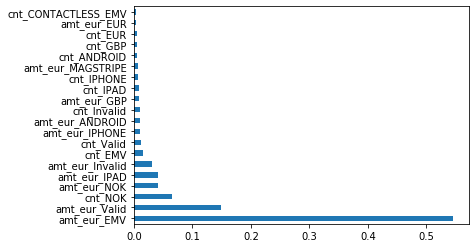

In [55]:
feat_importances_1.nlargest(20).plot(kind='barh')

<br>

### Feature Importance for Month 2 Model ###

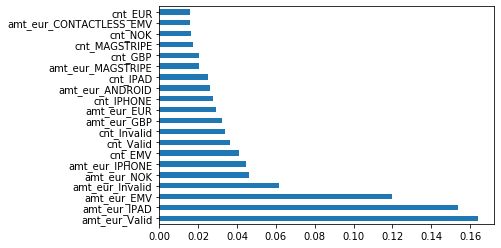

In [56]:
feat_importances_2.nlargest(20).plot(kind='barh')

<br>

### Feature Importance for Month 3 Model ###

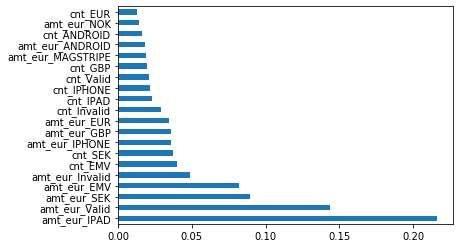

In [57]:
feat_importances_3.nlargest(20).plot(kind='barh')

<br>
<br>

## Saving the Model ##

In order to re-use our models in a RESTful API service, we need to save them to disk. We could use either joblib or pickle. Here we go with pickle.

In [58]:
pickle.dump(rf_model_1, open('rf_model_1.pickle', 'wb'))
pickle.dump(rf_model_2, open('rf_model_2.pickle', 'wb'))
pickle.dump(rf_model_3, open('rf_model_3.pickle', 'wb'))